In [1]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.optimizers import COBYLA
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, EfficientSU2
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms.classifiers import VQC
from IPython.display import clear_output

## Exploratory Data Analysis (EDA)

In [2]:
iris_data = load_iris()
print(iris_data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [3]:
features = iris_data.data
labels = iris_data.target

features = MinMaxScaler().fit_transform(features)

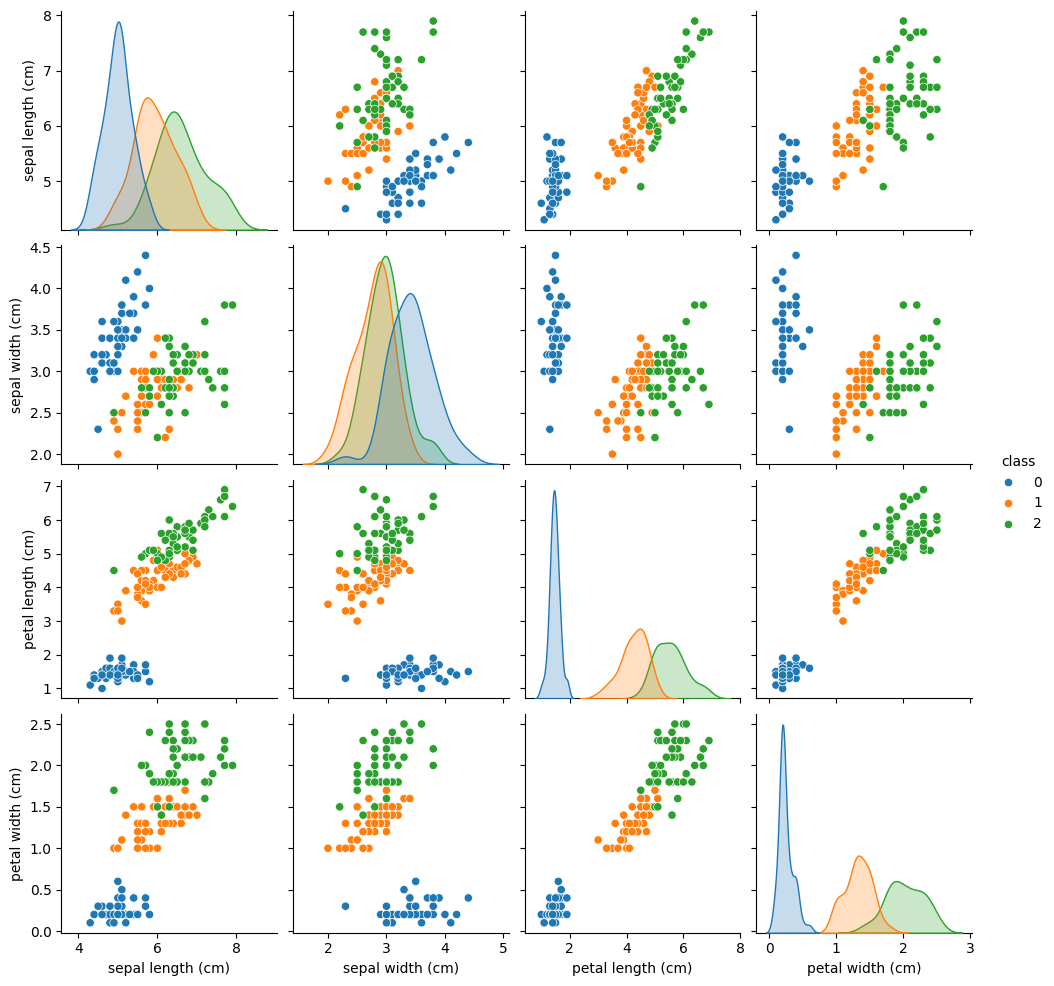

In [4]:
df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df['class'] = pd.Series(iris_data.target)

sns.pairplot(df, hue="class", palette='tab10')

## Classical Machine Learning

In [5]:
algorithm_globals.random_seed = 1234
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

svc = SVC()
_ = svc.fit(train_features, train_labels)

In [6]:
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset: {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.97
Classical SVC on the test dataset: 1.00


## Quantum Machine Learning

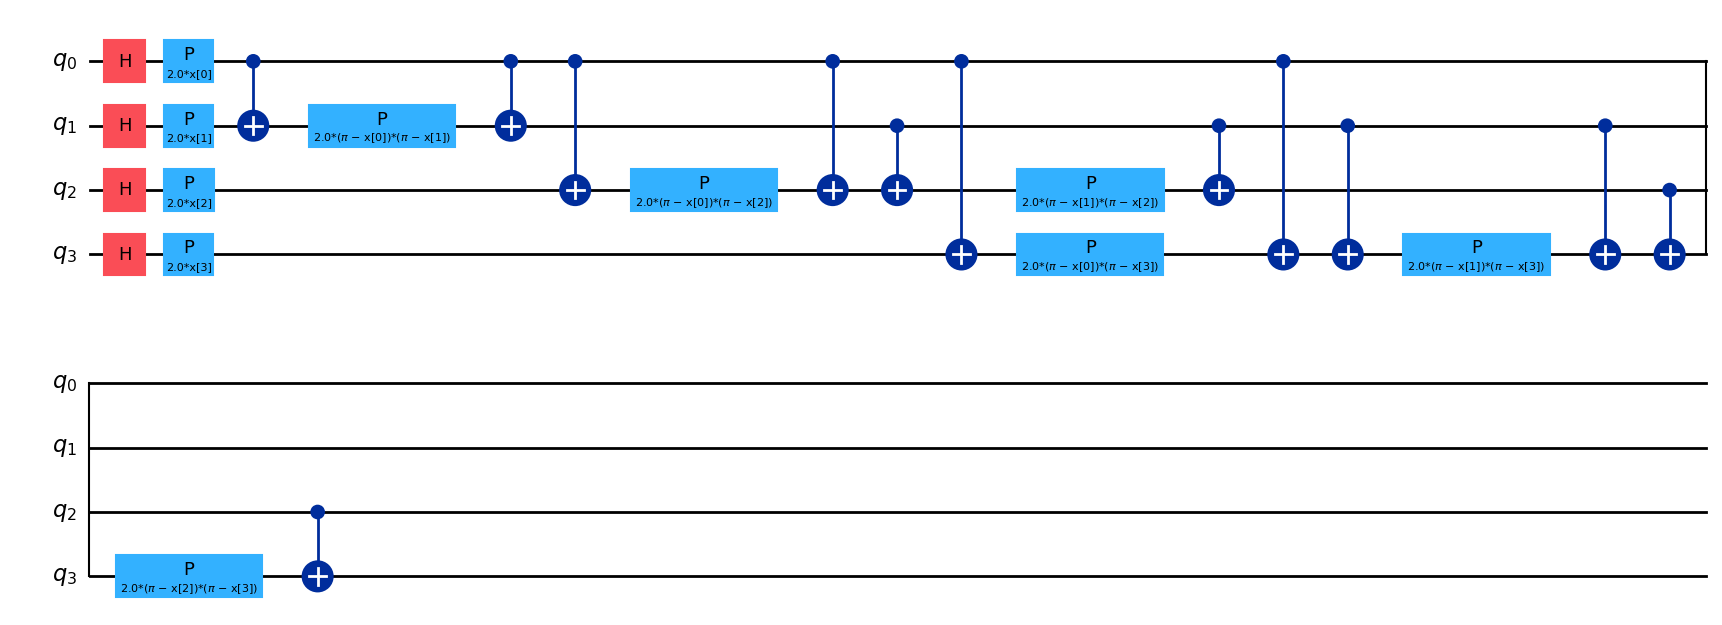

In [7]:
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw('mpl')

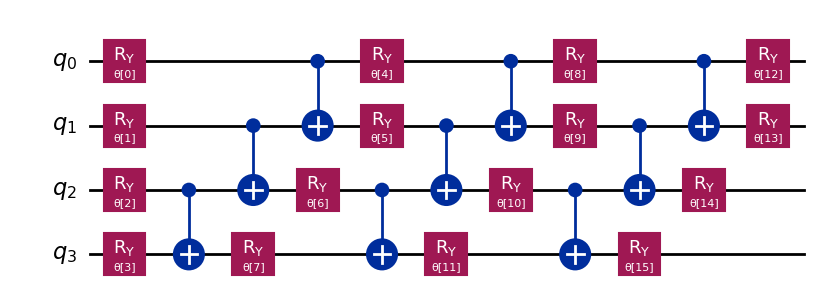

In [8]:
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw('mpl')

In [9]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

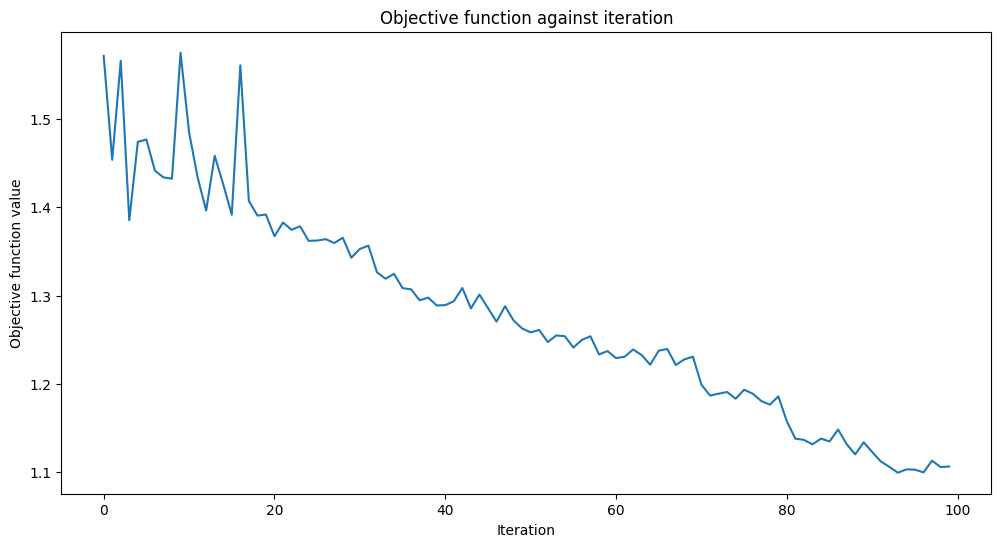

Training time: 29 seconds


In [10]:
optimizer = COBYLA(maxiter=100)
sampler = Sampler()

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph
)

objective_func_vals = [] # clear the previous vals

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [11]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset: {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.82
Quantum VQC on the test dataset: 0.70


## Fine-tuning

### Reducing number of features

<Axes: >

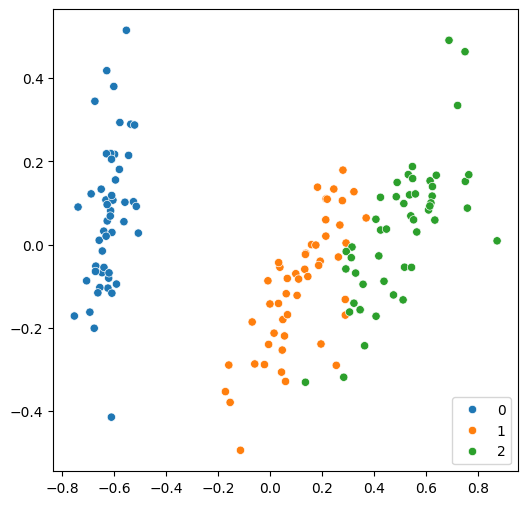

In [17]:
features = PCA(n_components=2).fit_transform(features)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette="tab10")

In [18]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

svc.fit(train_features, train_labels)

train_score_c2 = svc.score(train_features, train_labels)
test_score_c2 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c2:.2f}")
print(f"Classical SVC on the test dataset: {test_score_c2:.2f}")

Classical SVC on the training dataset: 0.95
Classical SVC on the test dataset: 1.00


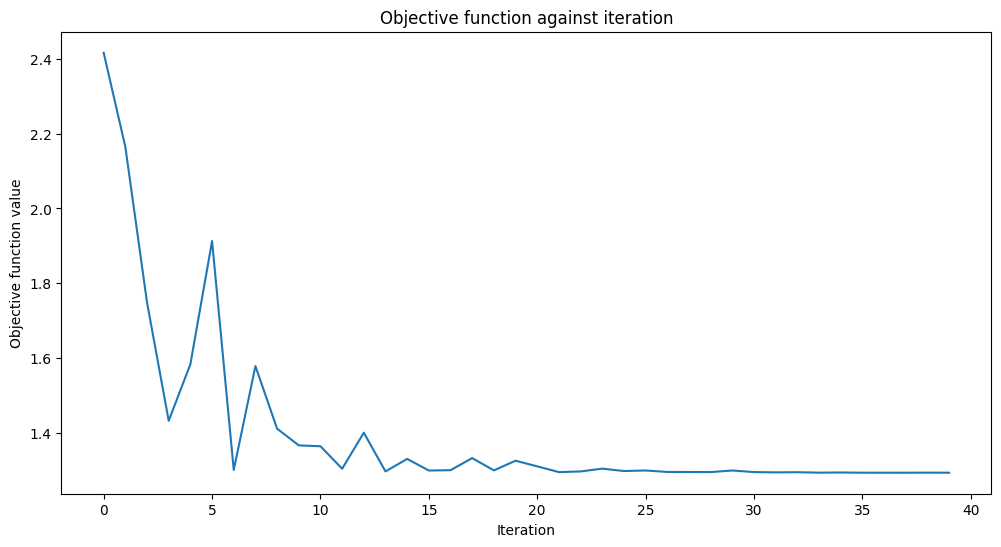

Training time: 8 seconds


In [19]:
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)

optimizer = COBYLA(maxiter=40)

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

objective_func_vals = []
plt.rcParams['figure.figsize'] = (12, 6)

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [20]:
train_score_q2_ra = vqc.score(train_features, train_labels)
test_score_q2_ra = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using RealAmplitudes: {train_score_q2_ra:.2f}")
print(f"Quantum VQC on the test dataset using RealAmplitudes: {test_score_q2_ra:.2f}")

Quantum VQC on the training dataset using RealAmplitudes: 0.57
Quantum VQC on the test dataset using RealAmplitudes: 0.63


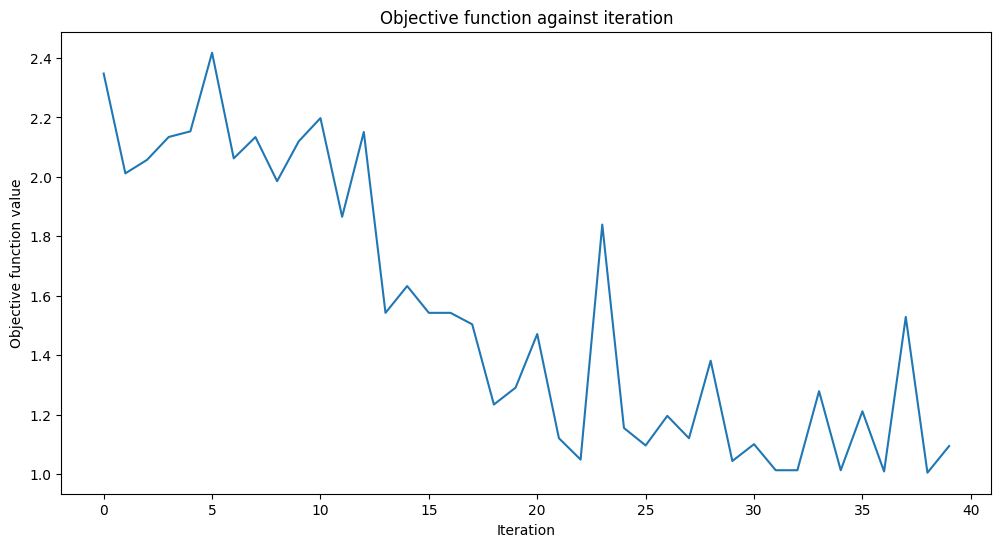

Training time: 13 seconds


In [22]:
ansatz = EfficientSU2(num_qubits=num_features, reps=3)
optimizer = COBYLA(maxiter=40)

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

objective_func_vals = []
plt.rcParams['figure.figsize'] = (12, 6)

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [23]:
train_score_q2_eff = vqc.score(train_features, train_labels)
test_score_q2_eff = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using EfficientSU2: {train_score_q2_eff:.2f}")
print(f"Quantum VQC on the test dataset using EfficientSU2: {test_score_q2_eff:.2f}")

Quantum VQC on the training dataset using EfficientSU2: 0.72
Quantum VQC on the test dataset using EfficientSU2: 0.67
